In [2]:
import os
from os.path import join
import re
import math
import pickle as pkl
import time
import numpy as np
import pandas as pd
from easydict import EasyDict as edict
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from neuro_data_analysis.mat_data_translate_lib import h5_to_dict_simplify, print_hdf5_info
# set the pandas display options width
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


mat_root = r"S:\Data-Ephys-MAT"
pkl_root = r"S:\Data-Ephys-PKL"
exp_record_pathdict = {"Alfa": r"S:\Exp_Record_Alfa.xlsx", 
                       "Beto": r"S:\ExpSpecTable_Augment.xlsx",
                       "Caos": r"S:\Exp_Record_Caos.xlsx",
                       "Diablito": r"S:\Exp_Record_Diablito.xlsx"}

ExpRecord_CD = pd.concat([pd.read_excel(exp_record_pathdict[Animal]) for Animal in ("Caos", "Diablito")])
exp_mask = ExpRecord_CD.Exp_collection.str.contains('BigGAN_Hessian', na=False) & ~ ExpRecord_CD.Expi.isna()
ExpRecord_Hessian = ExpRecord_CD.loc[exp_mask, :]
exp_mask = ExpRecord_CD.Exp_collection.str.contains('BigGAN_FC6', na=False) & ~ ExpRecord_CD.Expi.isna()
ExpRecord_Evol = ExpRecord_CD.loc[exp_mask, :]
print(ExpRecord_Hessian)
print(ExpRecord_Evol)

    ChanQual  Exp_collection  Expi  WebCam                                           comments                ephysFN                              expControlFN  pref_chan  pref_unit  stim_size                                            stimuli
12       NaN  BigGAN_Hessian   1.0     NaN  Manifold with biggan\n 003 at 309 PM, manifold...      Caos-12022024-003      241202_150857_Caos_selectivity_basic       91.0        NaN        NaN  N:\Stimuli\Evolutions\2024\2024-12-02-Ev-Caos-...
15       NaN  BigGAN_Hessian   2.0     NaN   006 manifold\n alas, it's all dogs\n 006 at 3...      Caos-12022024-006      241202_155547_Caos_selectivity_basic       94.0        NaN        NaN  N:\Stimuli\Evolutions\2024\2024-12-02-Ev-Caos-...
18       NaN  BigGAN_Hessian   3.0     NaN  003 at 239 PM\nmanifold\n(0,0) 2\nhas had arou...      Caos-12042024-003      241204_143902_Caos_selectivity_basic       71.0        NaN        2.0  N:\Stimuli\Evolutions\2024\2024-12-04-Ev-Caos-...
22       NaN  BigGAN_Hessian

In [52]:
for _, exprow in ExpRecord_Hessian.iterrows():
    print(exprow.ephysFN,exprow.Expi)
    data = pkl.load(open(join(pkl_root, f"{exprow.ephysFN}.pkl"), "rb"))
    rasters = data["rasters"]
    meta = data["meta"]
    Trials = data["Trials"]
    imageName = np.squeeze(Trials.imageName)
    stimuli_dir = exprow.stimuli
    break

Caos-12022024-003 1.0


In [25]:
# Organize the unit information
spikeID = meta.spikeID[0].astype(int)
channel_id = spikeID # set alias
unit_id = meta.unitID[0].astype(int)
char_map = {0:"U", 1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H'}
unit_str = [f"{channel_id}{char_map[unit_id]}" for channel_id, unit_id in zip(channel_id, unit_id)]
prefchan = exprow.pref_chan
prefchan_id_allunits = np.where((channel_id == prefchan))[0]
prefunit = 1 # the prefchan is the first unit???
prefchan_id = np.where((channel_id == prefchan) & (unit_id == prefunit))[0]
prefchan_str = unit_str[prefchan_id.item()]
prefchan_id_allunits

array([110, 111], dtype=int64)

In [70]:
import glob
def find_full_image_paths(folder_path, image_names):
    """
    Searches the specified folder for image files whose stem matches the given image names.

    Parameters:
        folder_path (str): Path to the folder containing the images.
        image_names (list of str): List of image name stems to search for.

    Returns:
        dict: A dictionary mapping each imageName to its full filename. If no matching file is found, the value is None.
    """
    files = glob.glob(os.path.join(folder_path, "*"))
    file_map = {}
    for f in files:
        stem = os.path.splitext(os.path.basename(f))[0]
        if stem in image_names:
            file_map[stem] = f
    return {img_name: file_map.get(img_name) for img_name in image_names}


def parse_stim_info(image_names):
    stim_info = []
    re_pattern = r'(noise|class)_eig(\d+)_lin([+-]?\d+\.\d+)'
    for name in image_names: 
        match = re.match(re_pattern, name)
        if match:
            space_name = match.groups()[0]
            eig_value = int(match.groups()[1])
            lin_value = float(match.groups()[2])
            stim_info.append({"img_name": name, "space_name": space_name, "eig_id": eig_value, "lin_dist": lin_value, "hessian_img": True, "trial_ids": indices_per_name[name]})
        else:
            stim_info.append({"img_name": name, "space_name": None, "eig_id": None, "lin_dist": None, "hessian_img": False, "trial_ids": indices_per_name[name]})

    stim_info_df = pd.DataFrame(stim_info)
    return stim_info_df


In [71]:
# parse the image name
unique_imgnames = np.unique(imageName)
uniq_img_full_path_dict = find_full_image_paths(stimuli_dir, unique_imgnames)
indices_per_name = {name: np.where(imageName == name)[0] for name in unique_imgnames} # indices of the trials with the same image name
stim_info_df = parse_stim_info(unique_imgnames)

In [66]:
noise_dist_list = np.sort(stim_info_df.loc[stim_info_df.space_name == 'noise', 'lin_dist'].unique())
noise_eig_list = np.sort(stim_info_df.loc[stim_info_df.space_name == 'noise', 'eig_id'].unique())
noise_idx_array = np.empty((len(noise_eig_list), len(noise_dist_list)), dtype=object)
for i, eig_id in enumerate(noise_eig_list):
    for j, dist in enumerate(noise_dist_list):
        mask = (stim_info_df.space_name == 'noise') & (stim_info_df.eig_id == eig_id) & (stim_info_df.lin_dist == dist)
        assert np.sum(mask) == 1, f"More than one trial found for eig_id {eig_id} and lin_dist {dist}"
        noise_idx_array[i, j] = stim_info_df.loc[mask, 'trial_ids'].values[0]


In [9]:
rasters.shape  # trials x time x units

(798, 200, 120)

In [82]:
from scipy import stats
# neural responses
wdw = slice(50, 200)
bslwdw = slice(0, 45)

respmat = rasters[:, wdw, :].mean(axis=1)
bslmat = rasters[:, bslwdw, :].mean(axis=1)
prefchan_resp_sgtr = respmat[:, prefchan_id] 
prefchan_bsl_sgtr = bslmat[:, prefchan_id]
prefchan_bsl_mean = prefchan_bsl_sgtr.mean()
prefchan_bsl_sem = stats.sem(prefchan_bsl_sgtr, axis=0)
# prefchan_bsl_sem = stats.sem(bslmat, axis=1)

In [83]:
prefchan_bsl_sem

array([1.3682147], dtype=float32)

In [11]:
sgtr_resp_df = pd.DataFrame({"img_name": imageName, "pref_unit_resp": prefchan_resp_sgtr[:, 0]})
sgtr_resp_df = sgtr_resp_df.merge(stim_info_df.drop(columns=['trial_ids']), on="img_name");
sgtr_resp_df.columns

Index(['img_name', 'pref_unit_resp', 'space_name', 'eig_id', 'lin_dist', 'hessian_img'], dtype='object')

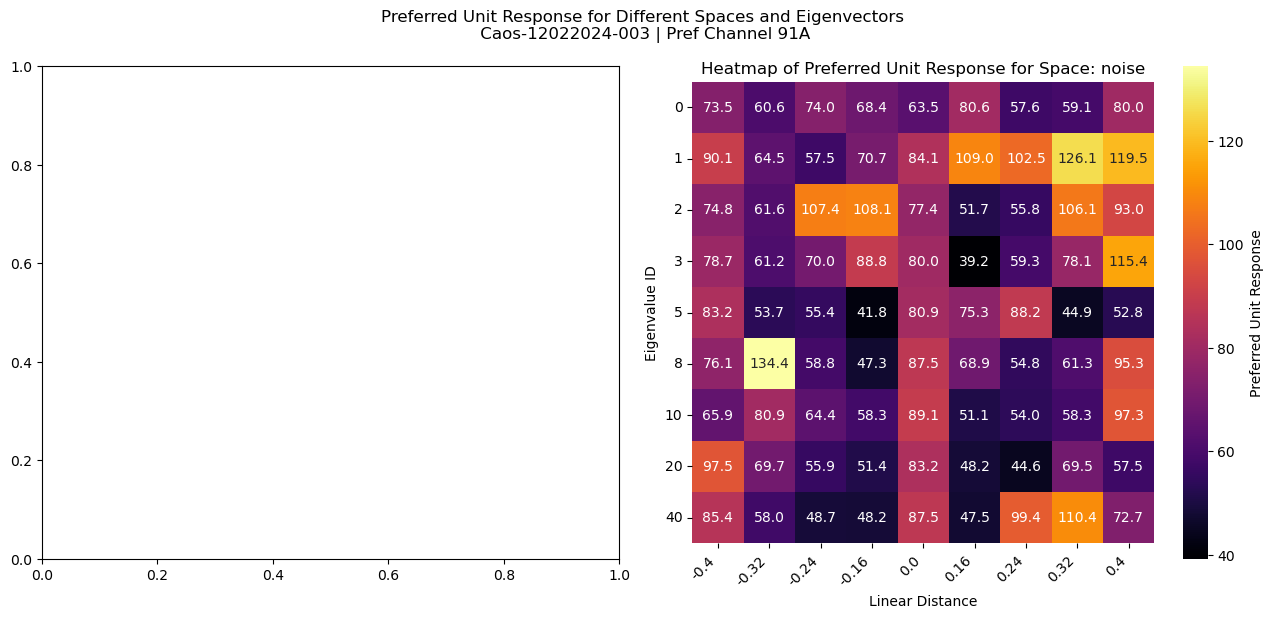

In [30]:
# Group by and compute the mean of preferred unit responses
grouped = sgtr_resp_df.groupby(['space_name', 'eig_id', 'lin_dist']).agg({'pref_unit_resp': 'mean'}).reset_index()
# Pivot the data to create a matrix for each space_name
space_names = grouped['space_name'].unique()
figh, axs = plt.subplots(1, 2, figsize=(13, 6))
for ax, space in zip(axs, ['class', 'noise',]):
    plt.sca(ax)
    space_data = grouped[grouped['space_name'] == space]
    pivot_table = space_data.pivot(index='eig_id', columns='lin_dist', values='pref_unit_resp') # set values as float
    pivot_table = pivot_table.astype(float)
    if pivot_table.empty:
        continue
    sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='inferno', 
                cbar_kws={'label': 'Preferred Unit Response'}, ax=ax)
    plt.title(f'Heatmap of Preferred Unit Response for Space: {space}')
    plt.xlabel('Linear Distance')
    plt.ylabel('Eigenvalue ID')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.axis('image')
plt.suptitle(f'Preferred Unit Response for Different Spaces and Eigenvectors \n {exprow.ephysFN} | Pref Channel {prefchan_str} ')
plt.tight_layout()
plt.show()

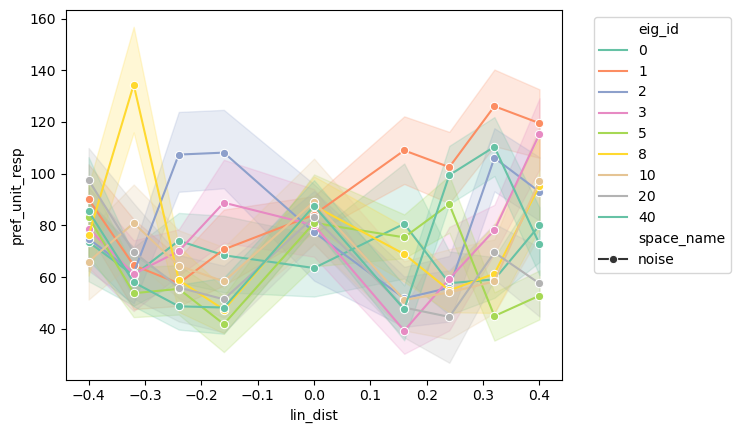

In [41]:
space = "noise"
sns.lineplot(data=sgtr_resp_df, x='lin_dist', y='pref_unit_resp', hue='eig_id', style='space_name', palette='Set2', markers=True)
# sns.scatterplot(data=sgtr_resp_df, x='lin_dist', y='pref_unit_resp', hue='eig_id', style='space_name', palette='Set2', legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

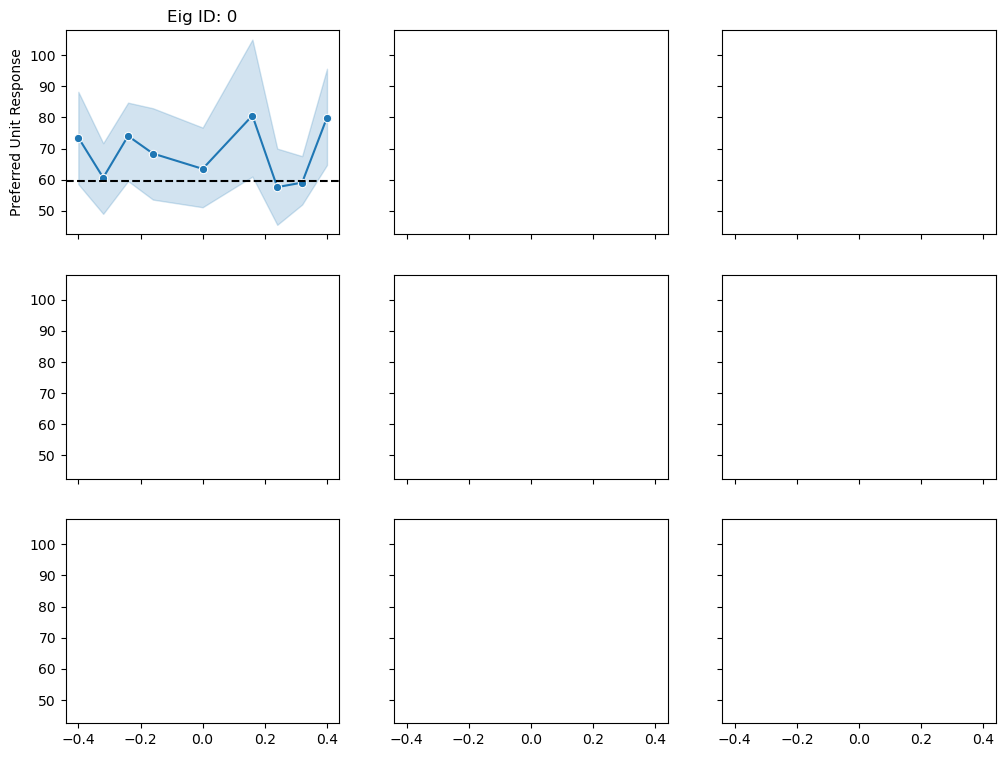

In [86]:

space = "noise"
filtered_df = sgtr_resp_df.query(f"space_name == '{space}'")
unique_eig_ids = sorted(filtered_df['eig_id'].unique())
num_eig_ids = len(unique_eig_ids)
# Determine grid size
cols = 3
rows = math.ceil(num_eig_ids / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True, sharey=True)
axs = axs.flatten()

for i, eig_id in enumerate(unique_eig_ids):
    ax = axs[i]
    subset = filtered_df[filtered_df['eig_id'] == eig_id]
    sns.lineplot(data=subset, x='lin_dist', y='pref_unit_resp', ax=ax, marker='o') # default to plot 95% confidence interval around the mean
    ax.set_title(f'Eig ID: {eig_id}')
    ax.set_xlabel('Linear Distance')
    ax.set_ylabel('Preferred Unit Response')
    ax.axhline(prefchan_bsl_mean, color='black', linestyle='--', label='Baseline Mean')
    ax.axhline(prefchan_bsl_mean + prefchan_bsl_sem, color='black', linestyle=':', label='Baseline SEM')
    ax.axhline(prefchan_bsl_mean - prefchan_bsl_sem, color='black', linestyle=':')

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle(f'Preferred Unit Response for Different Eigenvectors {space}\n {exprow.ephysFN} | Pref Channel {prefchan_str} ')
# plt.legend(title='Space Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Dev zone

In [ ]:
stim_info = []
re_pattern = r'(noise|class)_eig(\d+)_lin([+-]?\d+\.\d+)'
for name in unique_imgnames: 
    match = re.match(re_pattern, name)
    if match:
        space_name = match.groups()[0]
        eig_value = int(match.groups()[1])
        lin_value = float(match.groups()[2])
        stim_info.append({"img_name": name, "space_name": space_name, "eig_id": eig_value, "lin_dist": lin_value, "hessian_img": True, "trial_ids": indices_per_name[name]})
    else:
        stim_info.append({"img_name": name, "space_name": None, "eig_id": None, "lin_dist": None, "hessian_img": False, "trial_ids": indices_per_name[name]})

stim_info_df = pd.DataFrame(stim_info)
